# 2D FEM with ACM element

![image](\img\door_drawing2.png)

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.linalg import eig
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
from matplotlib import cm
from datetime import datetime

pi = np.pi

In [2]:
h = 1.6e-3 # thickness [m]
H = 500e-3 # door height [m]
L = 200e-3 # door length [m]
Iz = (h**3)/12 # corss section moment of inertia per length [m**3]
E = 186e9 # modulus of elasticity [Pa]
nu = 0.3 # poison coef
rho = 7870 # steel density [kg/m**3]

def m_e(dx, dy):
    a=dx/2
    b=dy/2
    m11 =  np.array([[3454,	    922*b,	    -922*a,	    1226,	398*b,	    548*a       ],
                    [922*b,	    320*b**2,	-252*a*b,	398*b,	160*b**2,	168*a*b     ],
                    [-922*a,    -252*a*b,	320*a**2,	-548*a,	-168*a*b,	-240*a**2   ],
                    [1226,	    398*b,	    -548*a,	    3454,	922*b,	    922*a       ],
                    [398*b,	    160*b**2,	-168*a*b,	922*b,	320*b**2,	252*a*b     ],
                    [548*a,	    168*a*b,	-240*a**2,	922*a,	252*a*b,	320*a**2    ]])

    m21 =  np.array([[394,	    323*b,	    -232*a,	    1226,	548*b,	    398*a       ],
                    [-232*b,	-120*b**2,	112*a*b,	-548*b,	-240*b**2,	-168*a*b    ],
                    [232*a,	    112*a*b,	-120*a**2,	398*a,	168*a*b,	160*a**2    ],
                    [1226,	    548*b,	    -398*a,	    394,	232*b,	    232*a       ],
                    [-548*b,	-240*b**2,	168*a*b,	-232*b,	-120*b**2,	-112*a*b    ],
                    [-398*a,	-168*a*b,	160*a**2,	-232*a,	-112*a*b,	-120*a**2   ]])
    
    m22 =   np.array([[3454,	-922*b,	    922*a,	    1226,	-398*b,	    -548*a      ],
                    [-922*b,	320*b**2,	-252*a*b,	-398*b,	160*b**2,	168*a*b     ],
                    [922*a,	    -252*a*b,	320*a**2,	548*a,	-168*a*b,	-240*a**2   ],
                    [1226,	    -398*b,	    548*a,	    3454,	-922*b,	    -922*a      ],
                    [-398*b,	160*b**2,	-168*a*b,	-922*b,	320*b**2,	252*a*b     ],
                    [-548*a,	168*a*b,	-240*a**2,	-922*a,	252*a*b,	320*a**2    ]])

    m = np.concatenate((np.concatenate((m11, m21.T), axis=1),  np.concatenate((m21, m22), axis=1)), axis=0)

    return (rho*h*a*b/6300)*m

def k_e(dx, dy):
    a=dx/2
    b=dy/2
    alp=a/b
    bet=b/a
    I1 = np.eye(3)
    I1[0,0]=-1
    I2 = np.eye(3)
    I2[1,1]=-1
    I3 = np.eye(3)
    I3[2,2]=-1

    k11 = np.array([[4*(bet**2+alp**2)+0.4*(7-2*nu),	    2*(2*alp**2+0.2*(1+4*nu))*b,	    2*(-2*bet**2-0.2*(1+4*nu))*a    ],
                    [2*(2*alp**2+0.2*(1+4*nu))*b,	        4*(4/3*alp**2+4/15*(1-nu))*b**2,	-4*nu*a*b                       ],
                    [2*(-2*bet**2-0.2*(1+4*nu))*a,	        -4*nu*a*b,                      	4*(4/3*bet**2+4/15*(1-nu))*a**2]])

    k21 = np.array([[-(2*(2*bet**2-alp**2)+0.4*(7-2*nu)),	2*(alp**2-0.2*(1+4*nu))*b,	        2*(2*bet**2+0.2*(1-nu))*a     ],
                    [2*(alp**2-0.2*(1+4*nu))*b,	            4*(2/3*alp**2-4/15*(1-nu))*b**2,    0                               ],
                    [-2*(2*bet**2+0.2*(1-nu))*a,	        0,                          	    4*(2/3*bet**2-1/15*(1-nu))*a**2]])

    k31 = np.array([[-(2*(bet**2+alp**2)-0.4*(7-2*nu)),	    2*(-alp**2+0.2*(1-nu))*b,	        2*(bet**2-0.2*(1-nu))*a      ],
                    [2*(alp**2-0.2*(1-nu))*b,	            4*(1/3*alp**2+1/15*(1-nu))*b**2,	0                               ],
                    [2*(-bet**2+0.2*(1-nu))*a,	            0,	                                4*(1/3*bet**2+1/15*(1-nu))*a**2]])

    k41 = np.array([[2*(bet**2-2*alp**2)-0.4*(7-2*nu),	    2*(-2*alp**2-0.2*(1-nu))*b,	        2*(-bet**2+0.2*(1+4*nu))*a      ],
                    [2*(2*alp**2+0.2*(1-nu))*b,	            4*(2/3*alp**2-1/15*(1-nu))*b**2,	0                               ],
                    [2*(-bet**2+0.2*(1+4*nu))*a,	        0,	                                4*(2/3*bet**2-4/15*(1-nu))*a**2]])

    k22 = I3.T @ k11 @ I3
    k32 = I3.T @ k41 @ I3
    k42 = I3.T @ k31 @ I3
    
    k33 = I1.T @ k11 @ I1
    k43 = I1.T @ k21 @ I1

    k44 = I2.T @ k11 @ I2

    aux1 = np.concatenate((k11, k21.T, k31.T, k41.T), axis=1)
    aux2 = np.concatenate((k21, k22, k32.T, k42.T), axis=1)
    aux3 = np.concatenate((k31, k32, k33, k43.T), axis=1)
    aux4 = np.concatenate((k41, k42, k43, k44), axis=1)
    k = np.concatenate((aux1, aux2, aux3, aux4), axis=0)

    
    return E*h**3/(48*(1-nu**2)*a*b)*k

# Mesh Definition

In [3]:
# Node coordinates
# 2D rectangular plate, square ACM elements
eSize = 0.01 # meters
nElementX = int(L/eSize)
nElementY = int(H/eSize)
nElements = nElementX * nElementY
dx = L / nElementX
dy = H / nElementY
nNodesX = nElementX + 1
nNodesY = nElementY + 1
nNodes = nNodesX * nNodesY
ndof = nNodes*3

# Degrees of Freedom
# Define the number of each DoF for each node
node_dof = np.arange(1, 3*nNodes+1).reshape((nNodes, 3))
node_dof = pd.DataFrame(columns=["w", "thetaX", "thetaY"], index=np.arange(1, nNodes+1), data=node_dof, dtype=int)
node_dof.index.rename("Node", inplace=True)
node_dof.rename_axis("DoF", axis="columns", inplace=True)

# Nodes coordinates
node_coor = np.zeros((nNodes, 2))
for n in range(1, nNodes+1):
    q, r = divmod(n-1, nNodesX) # quotient and remainder
    node_coor[n-1, 0] = r*dx
    node_coor[n-1, 1] = q*dy

node_coor = pd.DataFrame(columns=["x", "y"], index=np.arange(1, nNodes+1), data=node_coor)
node_coor.index.rename("Node", inplace=True)
node_coor.rename_axis("Coordinate", axis="columns", inplace=True)

# Conectivity matrix
# Relates local nodes of elements to dofobal nodes
element_con = np.zeros((nElements, 4))
for n in range(1, nElements+1):
    q, r = divmod(n, nElementX) # quotient and remainder
    if r == 0:
        q = q-1
        r = nElementX
    a = q*nNodesX + r
    element_con[n-1, 0] = a
    element_con[n-1, 1] = a + 1
    element_con[n-1, 2] = a + nNodesX + 1
    element_con[n-1, 3] = a + nNodesX

element_con = pd.DataFrame(columns=["1", "2", "3", "4"], index=np.arange(1, nElements+1), data=element_con, dtype=int)
element_con.index.rename("Element", inplace=True)
element_con.rename_axis("Local Node", axis="columns", inplace=True)

# Index table
# Relates the dofobal DoF associated with each element
index_table = np.zeros((nElements, 12))
for n in range(1, nElements+1):
    index_table[n-1, 0] = node_dof["w"][element_con["1"][n]] # w, local node 1
    index_table[n-1, 1] = node_dof["thetaX"][element_con["1"][n]] # thetaX, local node 1
    index_table[n-1, 2] = node_dof["thetaY"][element_con["1"][n]] # thetaY, locasl node 1

    index_table[n-1, 3] = node_dof["w"][element_con["2"][n]] # w, local node 2
    index_table[n-1, 4] = node_dof["thetaX"][element_con["2"][n]] # thetaX, local node 2
    index_table[n-1, 5] = node_dof["thetaY"][element_con["2"][n]] # thetaY, locasl node 2

    index_table[n-1, 6] = node_dof["w"][element_con["3"][n]] # w, local node 3
    index_table[n-1, 7] = node_dof["thetaX"][element_con["3"][n]] # thetaX, local node 3
    index_table[n-1, 8] = node_dof["thetaY"][element_con["3"][n]] # thetaY, locasl node 3

    index_table[n-1, 9] = node_dof["w"][element_con["4"][n]] # w, local node 4
    index_table[n-1, 10] = node_dof["thetaX"][element_con["4"][n]] # thetaX, local node 4
    index_table[n-1, 11] = node_dof["thetaY"][element_con["4"][n]] # thetaY, locasl node 4

col = pd.MultiIndex.from_arrays([["Local Node 1"]*3+ ["Local Node 2"]*3+ ["Local Node 3"]*3+ ["Local Node 4"]*3,
                                ["w", "thetaX", "thetaY"]*4])
index_table = pd.DataFrame(columns=col, index=np.arange(1, nElements+1), data=index_table, dtype=int)
index_table.index.rename("Element", inplace=True)

In [4]:
node_dof.head()

DoF,w,thetaX,thetaY
Node,,,
1,1,2,3
2,4,5,6
3,7,8,9
4,10,11,12
5,13,14,15


In [5]:
element_con.head()

Local Node,1,2,3,4
Element,,,,
1,1,2,23,22
2,2,3,24,23
3,3,4,25,24
4,4,5,26,25
5,5,6,27,26


In [6]:
index_table.head()

Local Node 1               Local Node 2               Local Node 3  \
                   w thetaX thetaY            w thetaX thetaY            w   
Element                                                                      
1                  1      2      3            4      5      6           67   
2                  4      5      6            7      8      9           70   
3                  7      8      9           10     11     12           73   
4                 10     11     12           13     14     15           76   
5                 13     14     15           16     17     18           79   

                      Local Node 4                
        thetaX thetaY            w thetaX thetaY  
Element                                           
1           68     69           64     65     66  
2           71     72           67     68     69  
3           74     75           70     71     72  
4           77     78           73     74     75  
5           80     81           76     77     78

# Assembly of [K] and [M]

In [7]:
start_assy = datetime.now()
K = np.zeros((ndof,ndof))
M = np.zeros((ndof,ndof))

Ke = k_e(dx, dy)
Me = m_e(dx, dy)

for n in range(1, nElements+1):
    Mee = np.zeros((ndof,ndof))
    Kee = np.zeros((ndof,ndof))
    idx = index_table.loc[n].to_list()
    for i, p in enumerate(idx):
        for j, q in enumerate(idx):
            Mee[p-1,q-1] = Me[i, j]
            Kee[p-1,q-1] = Ke[i, j]
    M += Mee
    K += Kee

finish_assy = datetime.now()
print("Elapsed time: ", finish_assy-start_assy)

Elapsed time:  0:01:00.462573


# Find nodes inside BC regions and remove fixed DoF from [K] and [M]

In [8]:
# Fixed boundary conditions: Two points rectandofe
region1 = np.array([[0.000, 0.100], [0.010, 0.120]])
region2 = np.array([[0.000, 0.380], [0.010, 0.400]])
region3 = np.array([[0.180, 0.240], [0.200, 0.280]])
regions = {1: region1, 2: region2, 3: region3}

fixed_dof = list()
fixed_nodes = list()
for r in regions.values():
    fixed_nodes += node_coor[(node_coor['x'].between(r[0][0], r[1][0])) & (node_coor['y'].between(r[0][1], r[1][1]))].index.tolist()

for node in fixed_nodes: 
    fixed_dof += node_dof.loc[node].tolist()

M_backup = M.copy()
K_backup = K.copy()
# Removing fixed DoF from the matrices
for j in range(1, len(fixed_dof)+1):
    M = np.delete(M, fixed_dof[j-1]-j, axis=1)
    M = np.delete(M, fixed_dof[j-1]-j, axis=0)
    K = np.delete(K, fixed_dof[j-1]-j, axis=1)
    K = np.delete(K, fixed_dof[j-1]-j, axis=0)

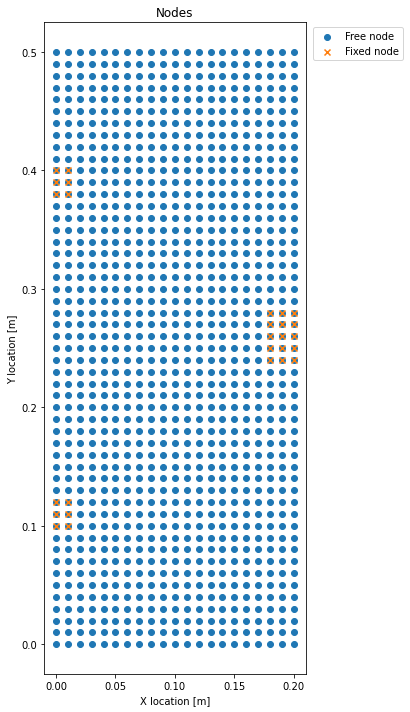

In [9]:
plt.figure(figsize=(30/5,50/5))
plt.scatter(x=node_coor['x'], y=node_coor['y'], label="Free node")
plt.scatter(x=node_coor['x'][fixed_nodes], y=node_coor['y'][fixed_nodes], marker='x', label='Fixed node')
plt.title("Nodes")
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1))
plt.xlabel("X location [m]")
plt.ylabel("Y location [m]")
plt.tight_layout()

In [10]:
np.savetxt(f"M_{eSize}.csv", M, delimiter=",")
np.savetxt(f"K_{eSize}.csv", K, delimiter=",")

In [11]:
# from numpy import genfromtxt
# M = genfromtxt('M_0.005.csv', delimiter=',')
# M = sp.sparse.bsr_matrix(M)
# K = genfromtxt('K_0.005.csv', delimiter=',')
# K = sp.sparse.bsr_matrix(K)

# Solve eignevalue problem

In [12]:
start_eig = datetime.now()
resultados = dict()

# Problema de autovalor generalizado. W é um vetor e A uma matrix com as colunas normalizadas
# W, Vc = eig(K, M)
M = sp.sparse.bsr_matrix(M)
K = sp.sparse.bsr_matrix(K)
W, Vc = eigsh(A=K, k=40, M=M, which='SM')

# Ordenando os autovalores e a matriz de autovetores
idx = W.argsort()
W = W[idx]
Vc = Vc[:,idx]
Vc_backup = Vc.copy()

# Normalizando os autovetores pela matriz de massa, de forma que A'@M@A = I
m_r = np.diagonal(Vc.T @ M @ Vc)
m_r = np.reciprocal(np.sqrt(m_r))
for a in range(Vc.shape[1]):
    Vc[:,a] *= m_r[a] # multiplica cada coluna pelo fator de escala
    
## Montando as formas modais
# Incluindo os dof das condições de contorno
for c in fixed_dof:
    Vc = np.insert(Vc, c-1, 0, axis=0)

resultados[nElements] = dict()
resultados[nElements]['fn'] = (W**0.5/(2*pi)).real
resultados[nElements]['V'] = Vc[0::3, :].real # Displacement shape (dof 1,4,7,10,13,...) 
resultados[nElements]['theta'] = np.delete(Vc, np.arange(0, Vc.shape[1]-1, 4), axis = 1).real # Angular shapes (dof 2,3,5,6,8,9,11,12,...)

# Faz as formas modais terem a mesma orientação
for j in range(1, W.size):
    if np.sum(resultados[nElements]['V'][:,j-1]) >= 0:
        pass
    else:
        resultados[nElements]['V'][:,j-1] *= -1

finish_eig = datetime.now()
print("Elapsed time: ", finish_eig-start_eig)

Elapsed time:  0:01:52.675427


In [13]:
np.savetxt(f"fn_{eSize}.csv", (W**0.5/(2*pi)).real, delimiter=",")
np.savetxt(f"Vc_{eSize}.csv", Vc_backup, delimiter=",")

In [14]:
n = np.array([nElements])
pd.options.display.float_format = "{:.2f}".format
pd.DataFrame(data=[resultados[n_b]['fn'] for n_b in n], index=[f"n={i}" for i in n], columns=[f"f_{j}" for j in range(1, len(resultados[n.max()]['fn'])+1)])

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40
n=1000,41.88,44.49,113.67,120.67,168.00,180.63,197.64,248.85,256.94,328.03,...,1146.94,1169.09,1177.08,1196.02,1262.99,1314.92,1331.44,1388.57,1448.54,1475.12


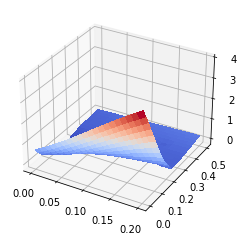

In [15]:
mode1 = resultados[nElements]['V'][:,0].reshape((nNodesY, nNodesX))

x = np.linspace(0, L, nNodesX)
y = np.linspace(0, H, nNodesY)

X, Y = np.meshgrid(x, y)
Z = mode1

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

In [16]:
z_data = pd.DataFrame(mode1)

fig = go.Figure(data=[go.Surface(z=z_data.values)])

fig.update_layout(title='First mode shape', autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()